In [189]:
import doctest
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from skimage import feature

from util import extract_ints

In [315]:
@dataclass
class Robot:
  p: np.array  # Position.
  v: np.array  # Velocity.
  
  @classmethod
  def parse_input(cls, input: str) -> 'Robot':
    x, y, vx, vy = extract_ints(input)
    p = np.array([x, y])
    v = np.array([vx, vy])
    return Robot(p, v)


@dataclass
class ProblemInput:
  robots: list[Robot]
  
  @classmethod
  def parse_input(cls, input: str) -> 'ProblemInput':
    return ProblemInput(
      [Robot.parse_input(l) for l in input.splitlines()]
    )


def step(p: np.array, v: np.array, w: int, h: int, t: int) -> np.array:
  """
  >>> step(np.array([2, 4]), np.array([2, -3]), w=11, h=7, t=5)
  array([1, 3])
  """
  return (p + v * t) % np.array([w, h])
  

def safety_factor(p: ProblemInput, w: int=101, h: int=103, t: int=100) -> int:
  ps = np.array([r.p for r in p.robots])
  vs = np.array([r.v for r in p.robots])
  final = step(ps, vs, w, h, t)
  xmid = w//2
  ymid = h//2
  q1 = sum((final[:, 0] > xmid) & (final[:, 1] < ymid))
  q2 = sum((final[:, 0] < xmid) & (final[:, 1] < ymid))
  q3 = sum((final[:, 0] < xmid) & (final[:, 1] > ymid))
  q4 = sum((final[:, 0] > xmid) & (final[:, 1] > ymid))
  return q1 * q2 * q3 * q4


def xy_correlation(ps: np.array) -> float:
  if ps.shape[0] < 2 or ps.shape[1] < 2:
    return 0
  return abs(stats.pearsonr(ps[:, 0], ps[:, 1], axis=0).statistic)


def tree_corr_metric(ps: np.array, h: int, w: int) -> float:
  xmid = w//2
  ymid = h//2
  q1 = xy_correlation(ps[(ps[:, 0] > xmid) & (ps[:, 1] < ymid)])
  q2 = xy_correlation(ps[(ps[:, 0] < xmid) & (ps[:, 1] < ymid)])
  q3 = xy_correlation(ps[(ps[:, 0] < xmid) & (ps[:, 1] > ymid)])
  q4 = xy_correlation(ps[(ps[:, 0] > xmid) & (ps[:, 1] > ymid)])
  return q1 * q2 * q3 * q4


def tree_var_metric(ps: np.array, h: int, w: int) -> float:
  from scipy.stats import variation
  vx, vy = variation(ps, axis=0)
  return -vx * vy
  

In [328]:
def part_1_solution(p: ProblemInput, w: int=101, h: int=103, t: int=100) -> int:
  # Safety factor.
  ps = np.array([r.p for r in p.robots])
  vs = np.array([r.v for r in p.robots])
  final = step(ps, vs, w, h, t)
  xmid = w//2
  ymid = h//2
  q1 = sum((final[:, 0] > xmid) & (final[:, 1] < ymid))
  q2 = sum((final[:, 0] < xmid) & (final[:, 1] < ymid))
  q3 = sum((final[:, 0] < xmid) & (final[:, 1] > ymid))
  q4 = sum((final[:, 0] > xmid) & (final[:, 1] > ymid))
  return q1 * q2 * q3 * q4


def part_2_solution(p: ProblemInput, w: int=101, h: int=11, max_t: int=10000,
                    figsize=(10, 11), metric_fn=tree_var_metric) -> int:
  ps = np.array([r.p for r in p.robots])
  vs = np.array([r.v for r in p.robots])

  best_metric = float('-inf')
  best_time = 0
  for t in (pbar := tqdm(range(max_t))):
    pbar.set_description(f"Best {best_metric} at t={best_time}")
    ps = step(ps, vs, w, h, 1)
    if (metric := metric_fn(ps, h, w)) > best_metric:
      best_metric = metric
      best_time = t + 1

  ps = np.array([r.p for r in p.robots])
  ps = step(ps, vs, w, h, best_time)
  data = np.zeros((h, w))
  data[ps[:, 1], ps[:, 0]] = 255

  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot()
  ax.matshow(data)
  ax.set_title(f't = {best_time}')
  fig.savefig(f'day14_{best_time}.png')
  
  return best_time

In [329]:
doctest.testmod(verbose=False, report=True, exclude_empty=True, optionflags=doctest.NORMALIZE_WHITESPACE)

TestResults(failed=0, attempted=1)

In [330]:
test_input = """p=0,4 v=3,-3
p=6,3 v=-1,-3
p=10,3 v=-1,2
p=2,0 v=2,-1
p=0,0 v=1,3
p=3,0 v=-2,-2
p=7,6 v=-1,-3
p=3,0 v=-1,-2
p=9,3 v=2,3
p=7,3 v=-1,2
p=2,4 v=2,-3
p=9,5 v=-3,-3"""

problem = ProblemInput.parse_input(test_input)
assert part_1_solution(problem, w=11, h=7, t=100) == 12, "p1 test failed"

Best -0.154143863252847 at t=75: 100%|██████████| 100/100 [00:00<00:00, 660.04it/s] 


75

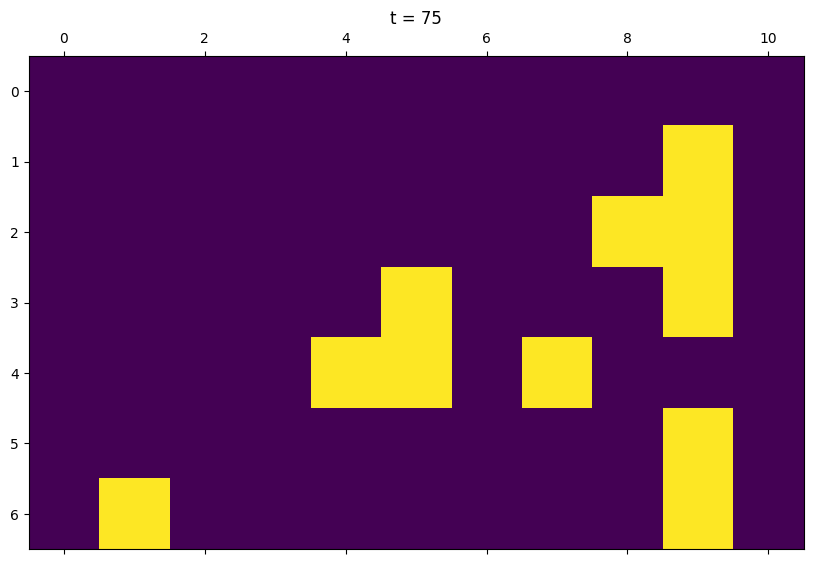

In [331]:
part_2_solution(problem, w=11, h=7, max_t=100)

Part 1:  214109808


Best -0.12571940435593185 at t=7687: 100%|██████████| 10000/10000 [00:14<00:00, 675.74it/s]


Part 2:  7687
CPU times: user 12.7 s, sys: 3.31 s, total: 16 s
Wall time: 15 s


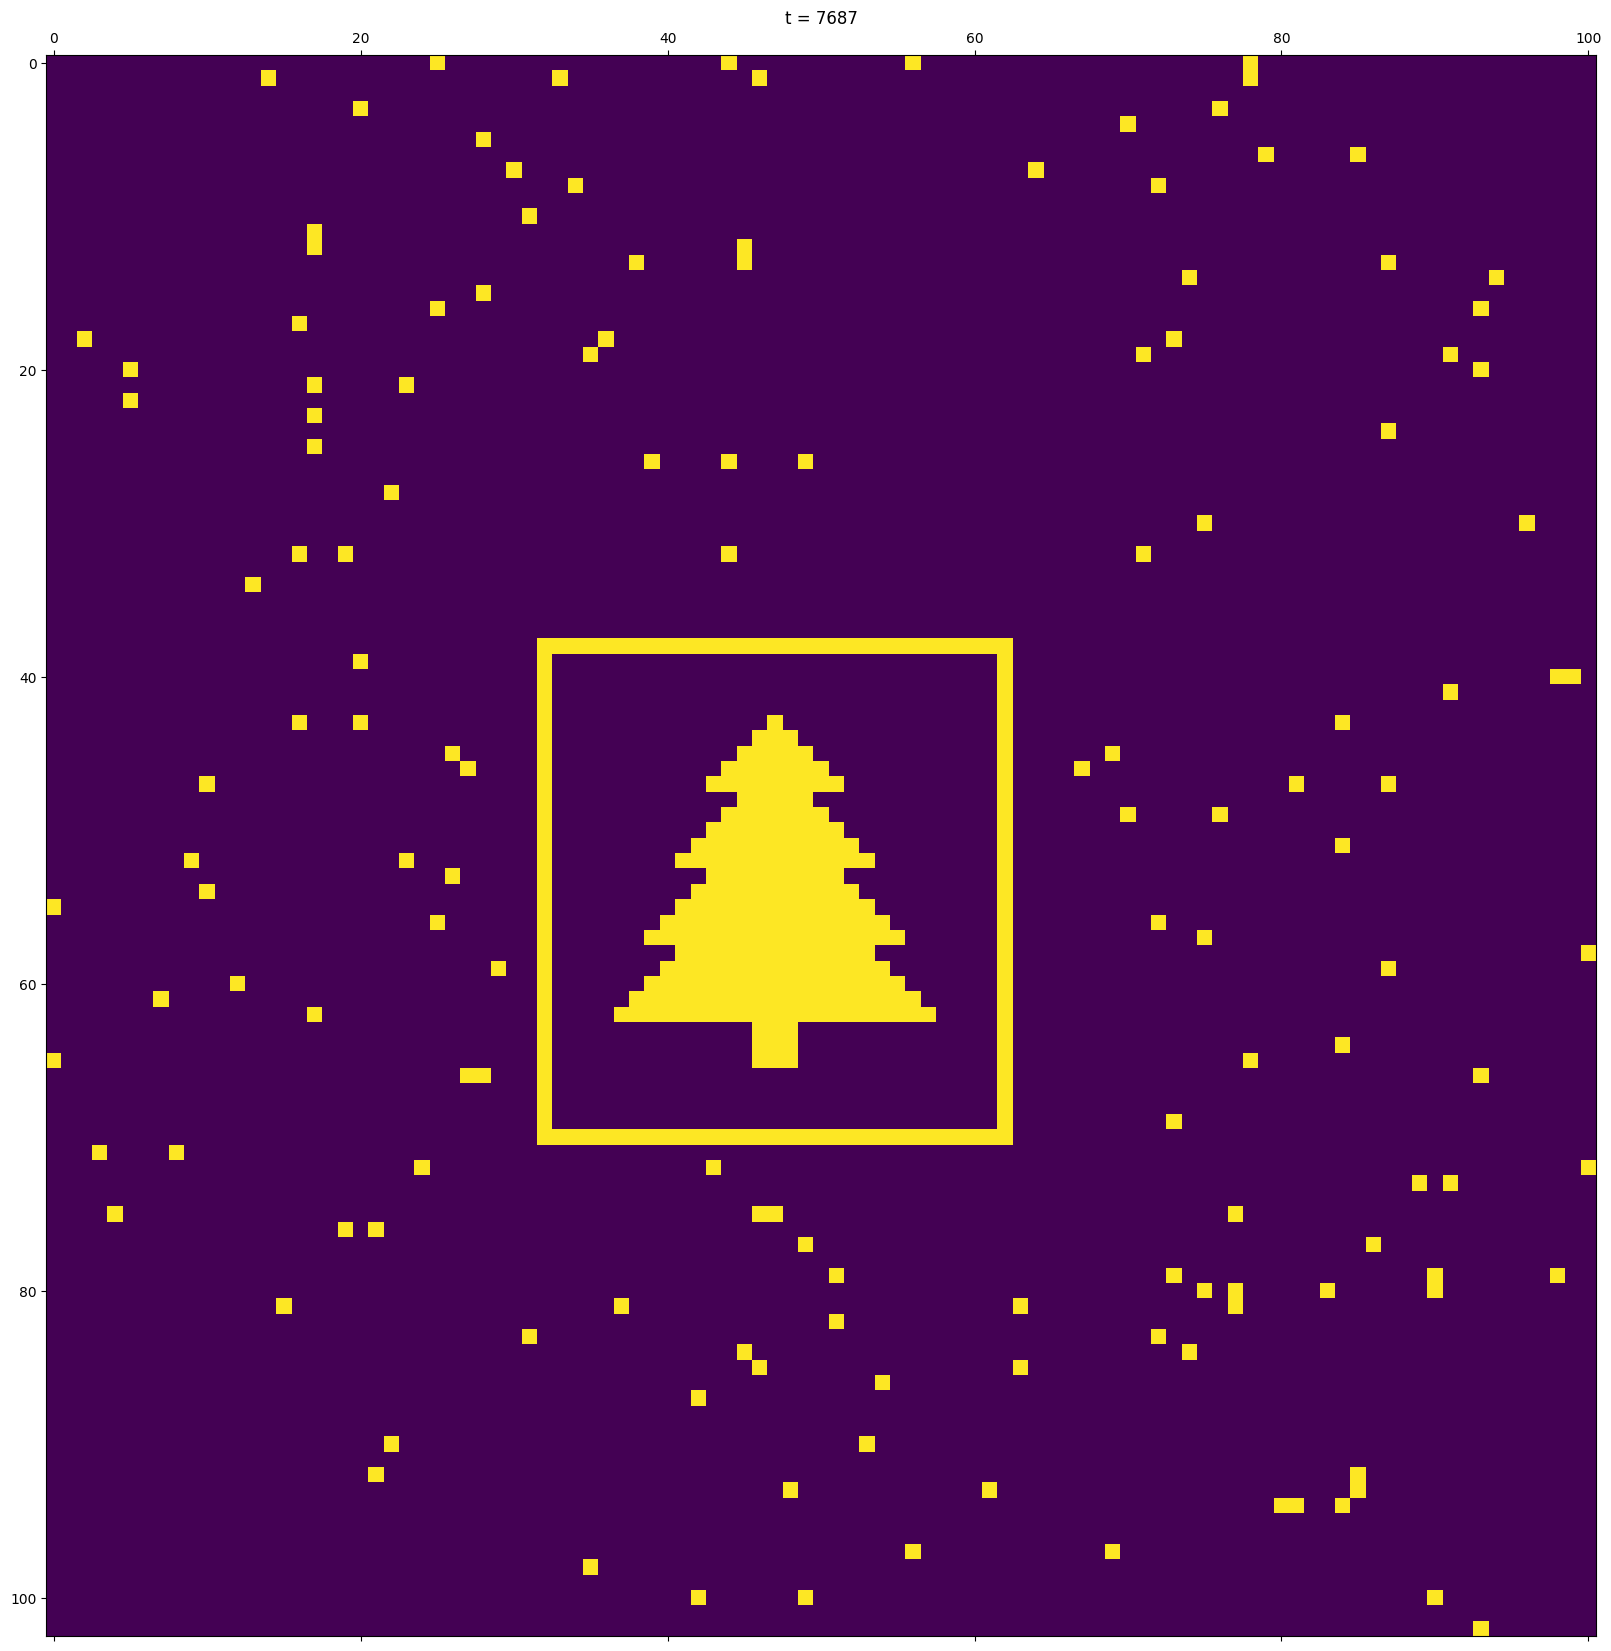

In [332]:
%%time
# Final answers
with open('inputs/day14.txt') as f:
    input = f.read().strip()
    problem = ProblemInput.parse_input(input)
    print('Part 1: ', part_1_solution(problem, w=101, h=103, t=100))
    print('Part 2: ', part_2_solution(problem, w=101, h=103, max_t=10000, figsize=(20, 24)))